# <font color=red>Planar fracture </font> 


## Import Libraries

In [1]:
import gmsh
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
# import FEM_Assembly as FEM
import FEM_2D as FEM
import time

## Define Functions  
### Meshing function

In [2]:
def generate_mesh(name=None,width=None,height=None,ms=None,mf=None):
    '''
    Creates mesh using Gmsh library
    
    Inputs
    ------
    name = name of the mesh
    width = width of the mesh 
    height = height of the mesh 
    ms = mesh size --> Divide width by number of desired elements
    mf = fracture mesh size --> divide width by the number of desired elements in the fracture
    
    Outputs
    -------
    mesh = mesh object
    pairs = nodes along the fracture (master and slave nodes)
    '''
    # Before using any functions in the Python API, Gmsh must be initialized:
    gmsh.initialize()
    gmsh.model.add(name) # model name

    # BOUNDARY NODES
    # The first type of `elementary entity' in Gmsh is a `Point'
    # - the first 3 arguments are the point coordinates (x, y, z)
    # - the next (optional) argument is the target mesh size close to the point
    # - the last (optional) argument is the point tag (a stricly positive integer
    #   that uniquely identifies the point)
    ll = gmsh.model.occ.addPoint(0,0,0,ms,1)
    lr = gmsh.model.occ.addPoint(width,0,0,ms,2)
    ur = gmsh.model.occ.addPoint(width,height,0,ms,3)
    ul = gmsh.model.occ.addPoint(0,height,0,ms,4)

    # BOUNDARY LINES
    # Curves are Gmsh's second type of elementery entities, and, amongst curves,
    # straight lines are the simplest. The API to create straight line segments with
    # the built-in kernel follows the same conventions: the first 2 arguments are
    # point tags (the start and end points of the line), and the last (optional one)
    # is the line tag.
    # Reservoir Area
    bt = gmsh.model.occ.addLine(ll,lr,1)
    rt = gmsh.model.occ.addLine(lr,ur,2)
    tp = gmsh.model.occ.addLine(ur,ul,3)
    lt = gmsh.model.occ.addLine(ul,ll,4)

    # BOUNDARY CURVE LOOP
    # The third elementary entity is the surface. In order to define a simple
    # rectangular surface from the four curves defined above, a curve loop has first
    # to be defined. A curve loop is defined by an ordered list of connected curves,
    # a sign being associated with each curve (depending on the orientation of the
    # curve to form a loop). The API function to create curve loops takes a list
    # of integers as first argument, and the curve loop tag (which must be unique
    # amongst curve loops) as the second (optional) argument:
    bd = gmsh.model.occ.addCurveLoop([bt,rt,tp,lt],1)

    # BOUNDARY SURFACE
    # We can then define the surface as a list of curve loops
    s = gmsh.model.occ.addPlaneSurface([bd])

    # FRACTURE GEOMETRY
    fl = gmsh.model.occ.addPoint(width*0.50,height*0.40,0,mf,5) # Lower fracture node
    fr = gmsh.model.occ.addPoint(width*0.50,height*0.60,0,mf,6) # Top fracture node

    fe = gmsh.model.occ.addLine(fl,fr) # Define boundary line for fracture

    #synchronize
    # Before they can be meshed (and, more generally, before they can be used by API
    # functions outside of the built-in CAD kernel functions), the CAD entities must
    # be synchronized with the Gmsh model, which will create the relevant Gmsh data
    # structures. This is achieved by the gmsh.model.geo.synchronize() API call for
    # the built-in CAD kernel.
    gmsh.model.occ.synchronize()

    gmsh.model.mesh.embed(1,[fe],2,s)
    gmsh.model.mesh.embed(0,[fl,fr],2,s)
    
    # We can then generate a 2D mesh
    gmsh.model.mesh.generate(2)
    gdim = 2 # Number of dimensions
    
    # Physical tags
    # Here we define a physical curve that groups curves in a single group
    gmsh.model.addPhysicalGroup(gdim-1, [bt],tag=1)
    gmsh.model.setPhysicalName(gdim-1, 1, 'Base')
    gmsh.model.addPhysicalGroup(gdim-1, [rt],tag=2)
    gmsh.model.setPhysicalName(gdim-1, 2, 'Right')
    gmsh.model.addPhysicalGroup(gdim-1, [tp],tag=3)
    gmsh.model.setPhysicalName(gdim-1, 3, 'Top')
    gmsh.model.addPhysicalGroup(gdim-1, [lt],tag=4)
    gmsh.model.setPhysicalName(gdim-1, 4, 'Left')
    gmsh.model.addPhysicalGroup(gdim-1, [fe],tag=5)
    gmsh.model.addPhysicalGroup(gdim, [s],tag=10)
    gmsh.model.setPhysicalName(gdim, 10, 'Omega')

    gmsh.model.addPhysicalGroup(gdim-2, [ur],tag=20)
    gmsh.model.setPhysicalName(gdim-2, 20, 'Point')

    gmsh.plugin.setNumber('Crack','Dimension',1)
    gmsh.plugin.setNumber('Crack','PhysicalGroup',5)
    gmsh.plugin.setNumber('Crack','NewPhysicalGroup',6)
    gmsh.plugin.run("Crack")
    gmsh.model.setPhysicalName(gdim-1, 5, 'Fracture_minus') # fracture left side (slave)
    gmsh.model.setPhysicalName(gdim-1, 6, 'Fracture_plus')  # fracture right side (master)

    gmsh.model.mesh.renumberNodes()
    gmsh.model.occ.synchronize()
    
    # extract node coordenates and node global connectivity
    cell_types, cell_tags, cell_node_tags = gmsh.model.mesh.getElements(dim=2)
    cell_tags = cell_tags[0]
    cell_node_tags = cell_node_tags[0].reshape((len(cell_tags),3))
    cell_node_tags -= 1
    
    node_tags, coord, param_coords = gmsh.model.mesh.getNodes()
    coord = coord.reshape((int(len(coord)/3),3))
    
    node_slave,coord_slave = gmsh.model.mesh.getNodesForPhysicalGroup(1,5)
    node_master,coord_master = gmsh.model.mesh.getNodesForPhysicalGroup(1,6)
    
    coord_slave = coord_slave.reshape((int(len(coord_slave)/3),3))
    coord_master = coord_master.reshape((int(len(coord_master)/3),3))

    gmsh.finalize()
    
    k = 0
    h = np.zeros(len(cell_node_tags))
    for tri in cell_node_tags:
        x0, y0, z0 = coord[tri[0]]
        x1, y1, z1 = coord[tri[1]]
        x2, y2, z2 = coord[tri[2]]
        a = np.sqrt((x0-x1)**2+(y0-y1)**2+(z0-z1)**2)
        b = np.sqrt((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
        c = np.sqrt((x0-x2)**2+(y0-y2)**2+(z0-z2)**2)
        s = 0.5*(a+b+c)
        h[k] = 2*a*b*c/4/np.sqrt(s*(s-a)*(s-b)*(s-c))
        k += 1

    mesh = (coord,cell_node_tags)
    contact_node,contact_coord = (node_slave,node_master), (coord_slave,coord_master)
    pairs = np.zeros([len(contact_node[0]),2],dtype=int)

    for i in range(len(contact_node[0])):
        for j in range(len(contact_node[1])):
            if np.all(np.isclose(coord_slave[i,:],coord_master[j,:])):
                pairs[i,0] = contact_node[0][i] - 1
                pairs[i,1] = contact_node[1][j] - 1

    idx = np.where(pairs[:,0] == pairs[:,1])[0]
    pairs = np.delete(pairs,idx,axis=0)
    
    return mesh, pairs, h
        

## Miscelaneous Functions

In [3]:
def residual(K,F,u):
    return K.dot(u) - F.toarray().reshape(len(u))

def L2_norm(K,F,u):
    return np.linalg.norm(residual(K,F,u))

## Fracture Aperture Function

In [4]:
def aperture(u,pairs,nx,ny):
    return (u[0::2][pairs[:,0]] - u[0::2][pairs[:,1]])*nx + (u[1::2][pairs[:,0]] - u[1::2][pairs[:,1]])*ny
    

## Plotting Functions
### Plot Deformed configuration

In [5]:
def plot_deformed(mesh,mesh_d,title, data=None):
    coord,node = mesh
    x,y,z = coord[:,0],coord[:,1],coord[:,2]
    
    coord2,node2 = mesh_d
    x2,y2,z2 = coord2[:,0],coord2[:,1],coord2[:,2]
    
    fig = plt.figure(dpi=300)
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim([x.min()-1,x.max()+1])
    ax.set_ylim([y.min()-1,y.max()+1])
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    
    if data is not None:
        if len(data) == len(coord):
            mag = data
        else:
            ux = data[0::2]
            uy = data[1::2]
            mag = np.sqrt(ux**2+uy**2)
        tric = ax.tricontourf(x2,y2,node2,mag,55,cmap='Spectral')
        cbar = plt.colorbar(tric, shrink=0.8)
        cbar.set_label('Displacement [m]')
    ax.triplot(x,y,node,color='k',linewidth=0.5)
    plt.show()
    return None


In [6]:
def move_mesh(mesh, u, scale):
    coord,node = mesh
    num_points = len(coord)
    assert(len(u) == num_points*2)
    # Make the displacement vector into a (np x 2) array
    v = u.reshape((num_points, 2))
    # Add displacement on to point positions
    for (x, dx) in zip(coord[:,0:2], v):
        x += dx*scale

## Solve 
- Domain = 100 x 100 m 
- Fracture length = 20 m 

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.0007455s, CPU 0.000899s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00593071s, CPU 0.005779s)
Info    : 140 nodes 294 elements
Info    : Running Plugin(Crack)...
Info    : Done running Plugin(Crack)


/opt/anaconda3/envs/research/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/envs/research/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


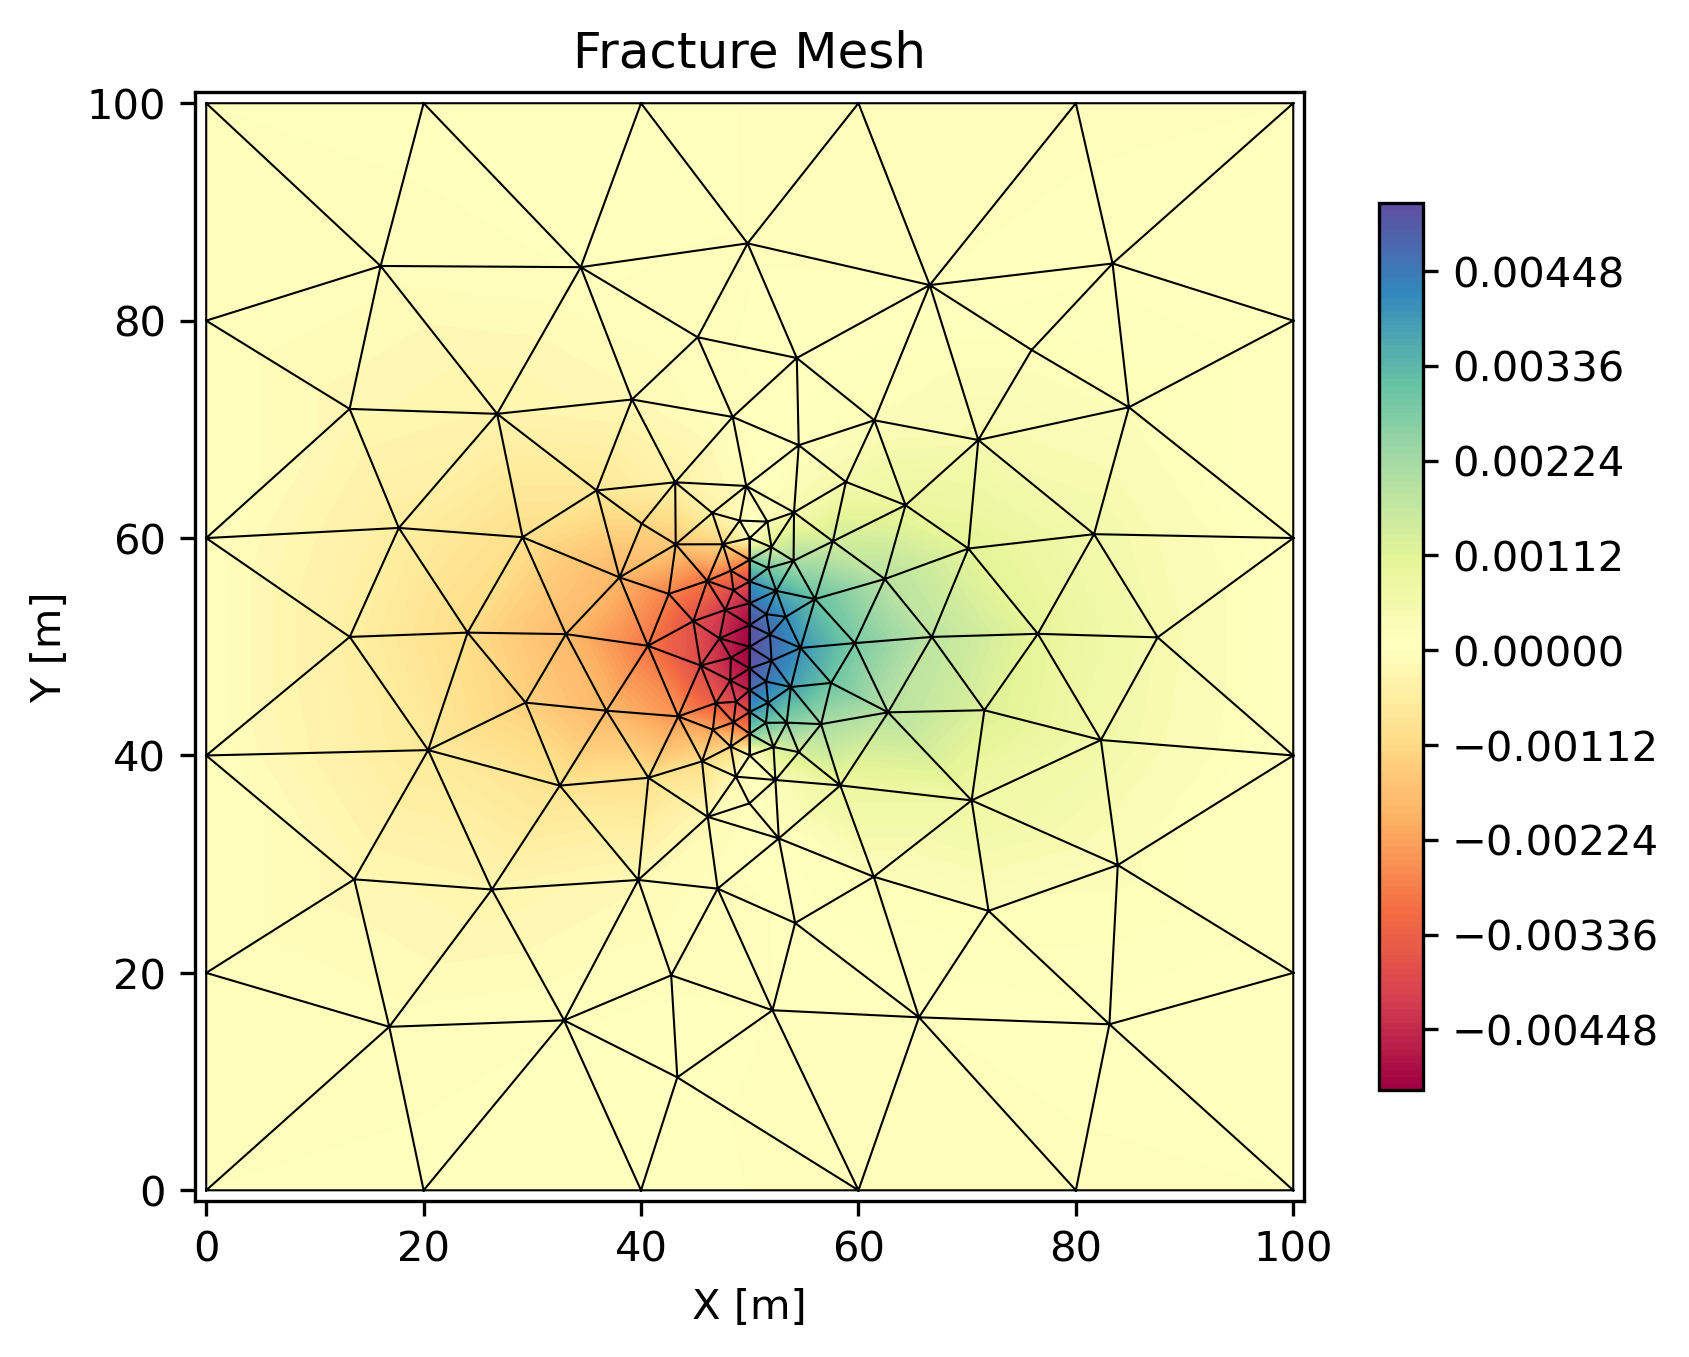

Time taken: 0.9794878959655762 seconds


In [7]:
start_time = time.time()

mesh,pairs,cell_diameter = generate_mesh(name="Fracture",width=100,height=100,ms=20.0,mf=2)
'''
Fracture Domain 
Width = 100 m
height = 100 m
mesh size = 10 elements on each side --> 100/10 = 10
fracture mesh = 50 elements --> 100/50 = 2
'''
#height/10
#fracture height/20
# OLD ---------------------------------------------------
# dof_top = np.where(np.isclose(mesh[0][:,1],10))[0]
# dof_base = np.where(np.isclose(mesh[0][:,1],0))[0]
# dof_left = np.where(np.isclose(mesh[0][:,0],0))[0]
# dof_right = np.where(np.isclose(mesh[0][:,0],10))[0]

# unique, counts = np.unique(mesh[0],return_counts=True)
# num_top_nodes = counts[np.where(unique == 10)[0]]
# dof_top_bd = np.where((mesh[0][dof_top,0] == 0) | (mesh[0][dof_top,0] == 10))[0]
# OLD ---------------------------------------------------

# NEW ===================================================
dof = {'top': [], 'base': [], 'left': [], 'right':[], 'master':[], 'slave':[]}
dof['top'] = np.where(np.isclose(mesh[0][:,1],np.max(mesh[0][:,1])))[0]
dof['base'] = np.where(np.isclose(mesh[0][:,1],0))[0]
dof['left'] = np.where(np.isclose(mesh[0][:,0],0))[0]
dof['right'] = np.where(np.isclose(mesh[0][:,0],np.max(mesh[0][:,0])))[0]
dof['master'] = pairs[:,0]
dof['slave'] = pairs[:,1]
# NEW ===================================================


# Mechanical properties:
# E = 30 GPa
# v --> nu = 0.2

E,nu = 30e9,0.20
G = E/2/(1+nu)
D = E/((1+nu)*(1-2*nu))*np.array([[1-nu,nu,0],
                                  [nu,1-nu,0],
                                  [0,0,(1-2*nu)/2]])
# OLD ---------------------------------------------------
# Kn = E/min(cell_diameter)
# Kn = 0
# K_global = FEM.assemble_matrix(mesh,D)
# F_global = scipy.sparse.csr_matrix((len(mesh[0])*2,1),dtype=np.float32) #initialization

# FEM.set_bc(K_global,F_global,dof_base,0.0,'y')
# FEM.set_bc(K_global,F_global,dof_top,0.0,'y')
# FEM.set_bc(K_global,F_global,dof_left,0.0,'x')
# FEM.set_bc(K_global,F_global,dof_right,0.0,'x')


# master = pairs[:,0]
# slave = pairs[:,1]

# F_global[2*master] = 10e6/(len(master)-1) #Number of cells on top!!
# F_global[2*slave] = -10e6/(len(slave)-1) #Number of cells on top!!
# OLD ---------------------------------------------------

# NEW ===================================================
K_global = FEM.assemble_matrix(mesh,D)
F_global = scipy.sparse.csr_matrix((len(mesh[0])*2,1),dtype=np.float32)

FEM.set_bc(K_global,F_global,dof['base'],0.0,'y')
FEM.set_bc(K_global,F_global,dof['left'],0.0,'x')
FEM.set_bc(K_global,F_global,dof['right'],0.0,'x')
FEM.set_bc(K_global,F_global,dof['top'],0.0,'y')

FEM.boundary_load(mesh,F_global,-10.0e6,dof['slave'],'x')
FEM.boundary_load(mesh,F_global,10.0e6,dof['master'],'x') 
# NEW ===================================================


# nx,ny = np.cos(np.radians(45)), -np.sin(np.radians(45))
# nx,ny = np.cos(np.radians(90)), -np.sin(np.radians(90))
nx, ny = 1, 0 #1, 0
# FEM.contact_kernel(K_global,Kn,pairs,nx,ny)

# u = scipy.sparse.linalg.spsolve(K_global,F_global,permc_spec='COLAMD',use_umfpack=True)
u = scipy.sparse.linalg.spsolve(K_global,F_global) #new
# more than 10K dof used a different solver 
ux = u[0::2]
uy = u[1::2]
FEM.plot(mesh, 'Fracture Mesh',ux)

end_time = time.time()

total_time = end_time - start_time

print(f"Time taken: {total_time} seconds")

In [8]:
print(pairs) #nodes at each fracture face

[[22 31]
 [23 32]
 [24 33]
 [25 34]
 [26 35]
 [27 36]
 [28 37]
 [29 38]
 [30 39]]


## Compute Fracture width

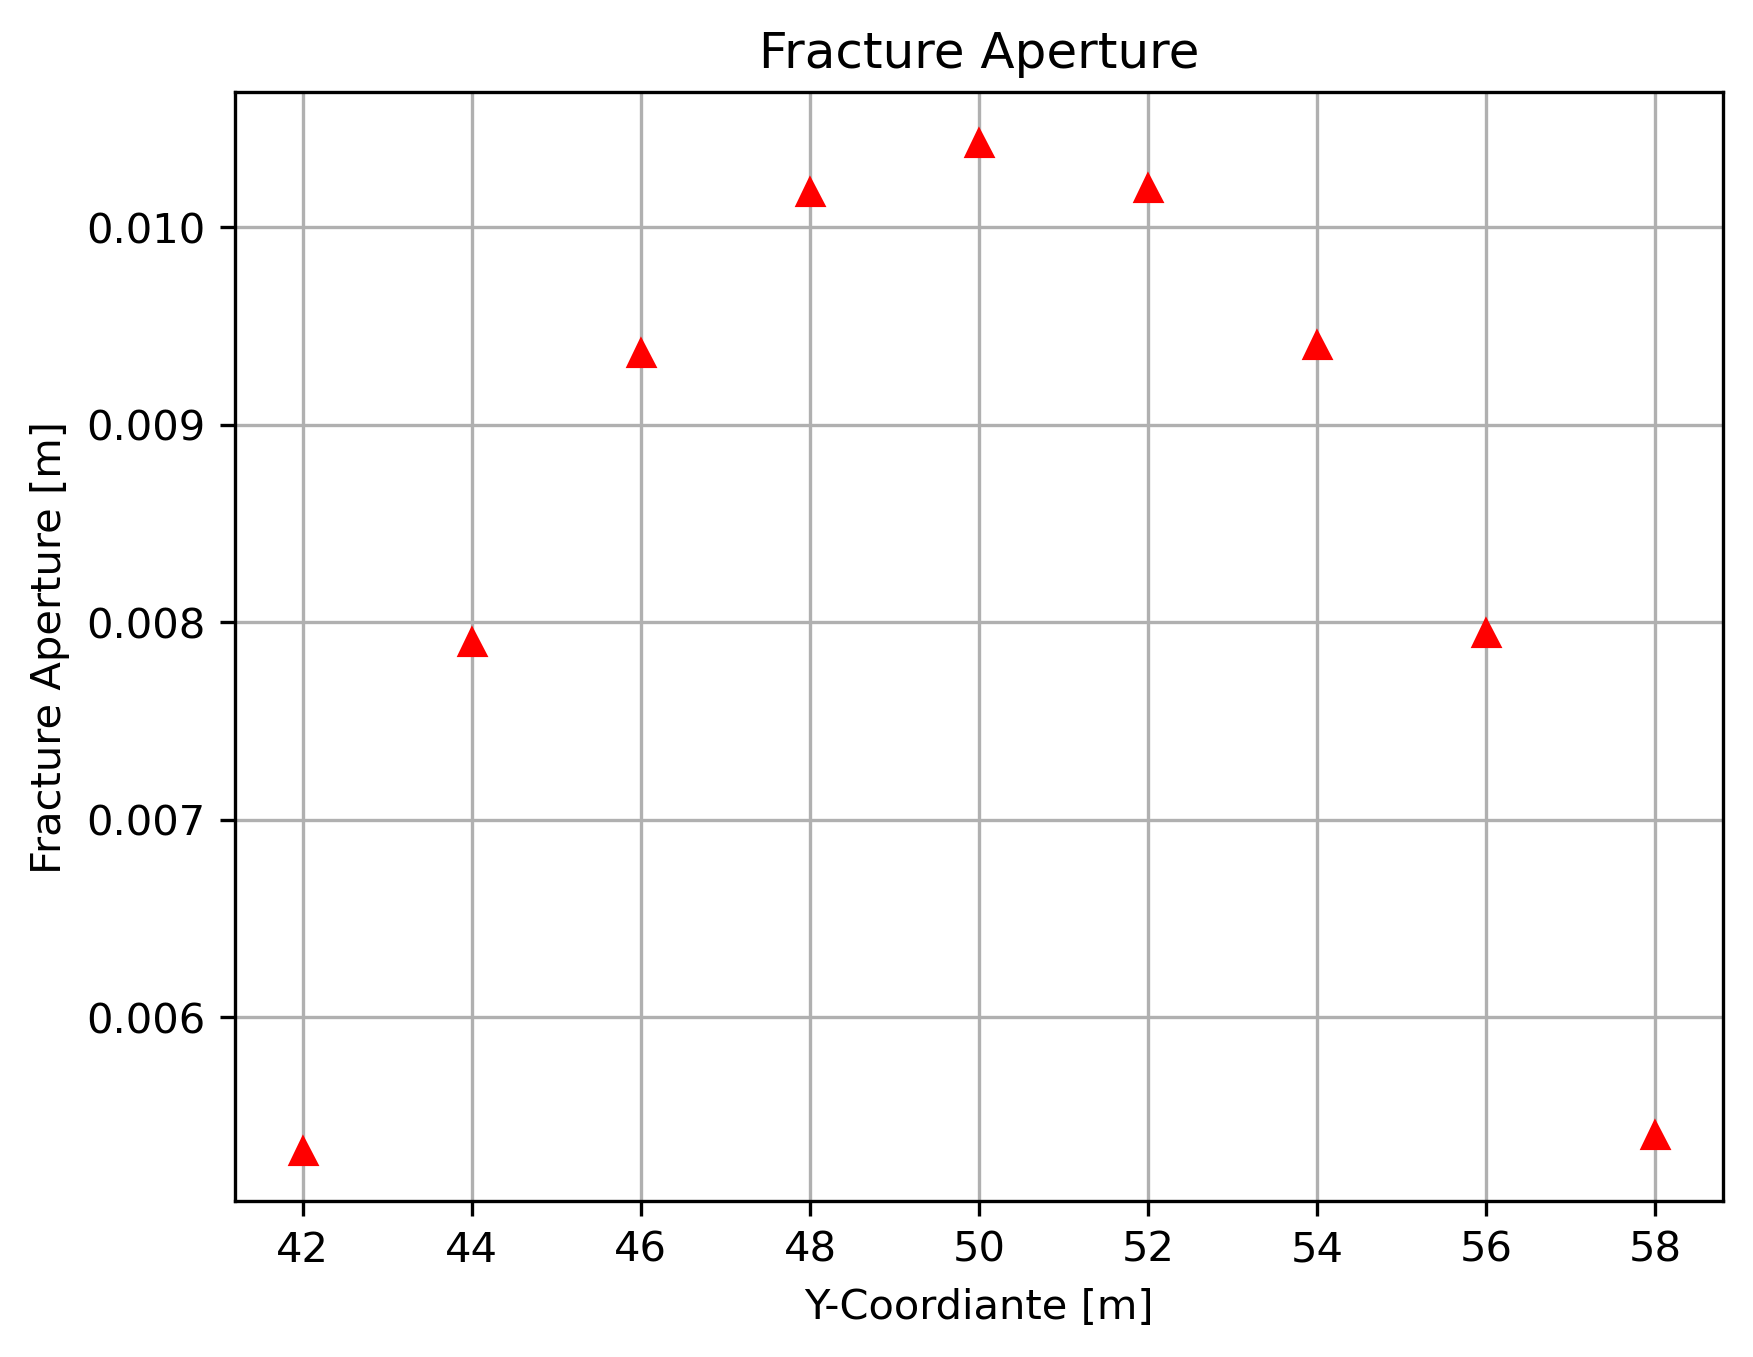

In [9]:
# # Compute Fracture Aperture
aperture = aperture(u,pairs,nx, ny)  #aperture = aperture(u,pairs,nx,ny) nx=1, ny=0
res = L2_norm(K_global,F_global,u)


fig = plt.figure(dpi=300)
plt.plot(mesh[0][pairs[:,0],1],aperture,'r^')
plt.xlabel('Y-Coordiante [m]')
plt.ylabel('Fracture Aperture [m]')
plt.title('Fracture Aperture')
plt.grid()
plt.show()

## Plot Deformed Configuration

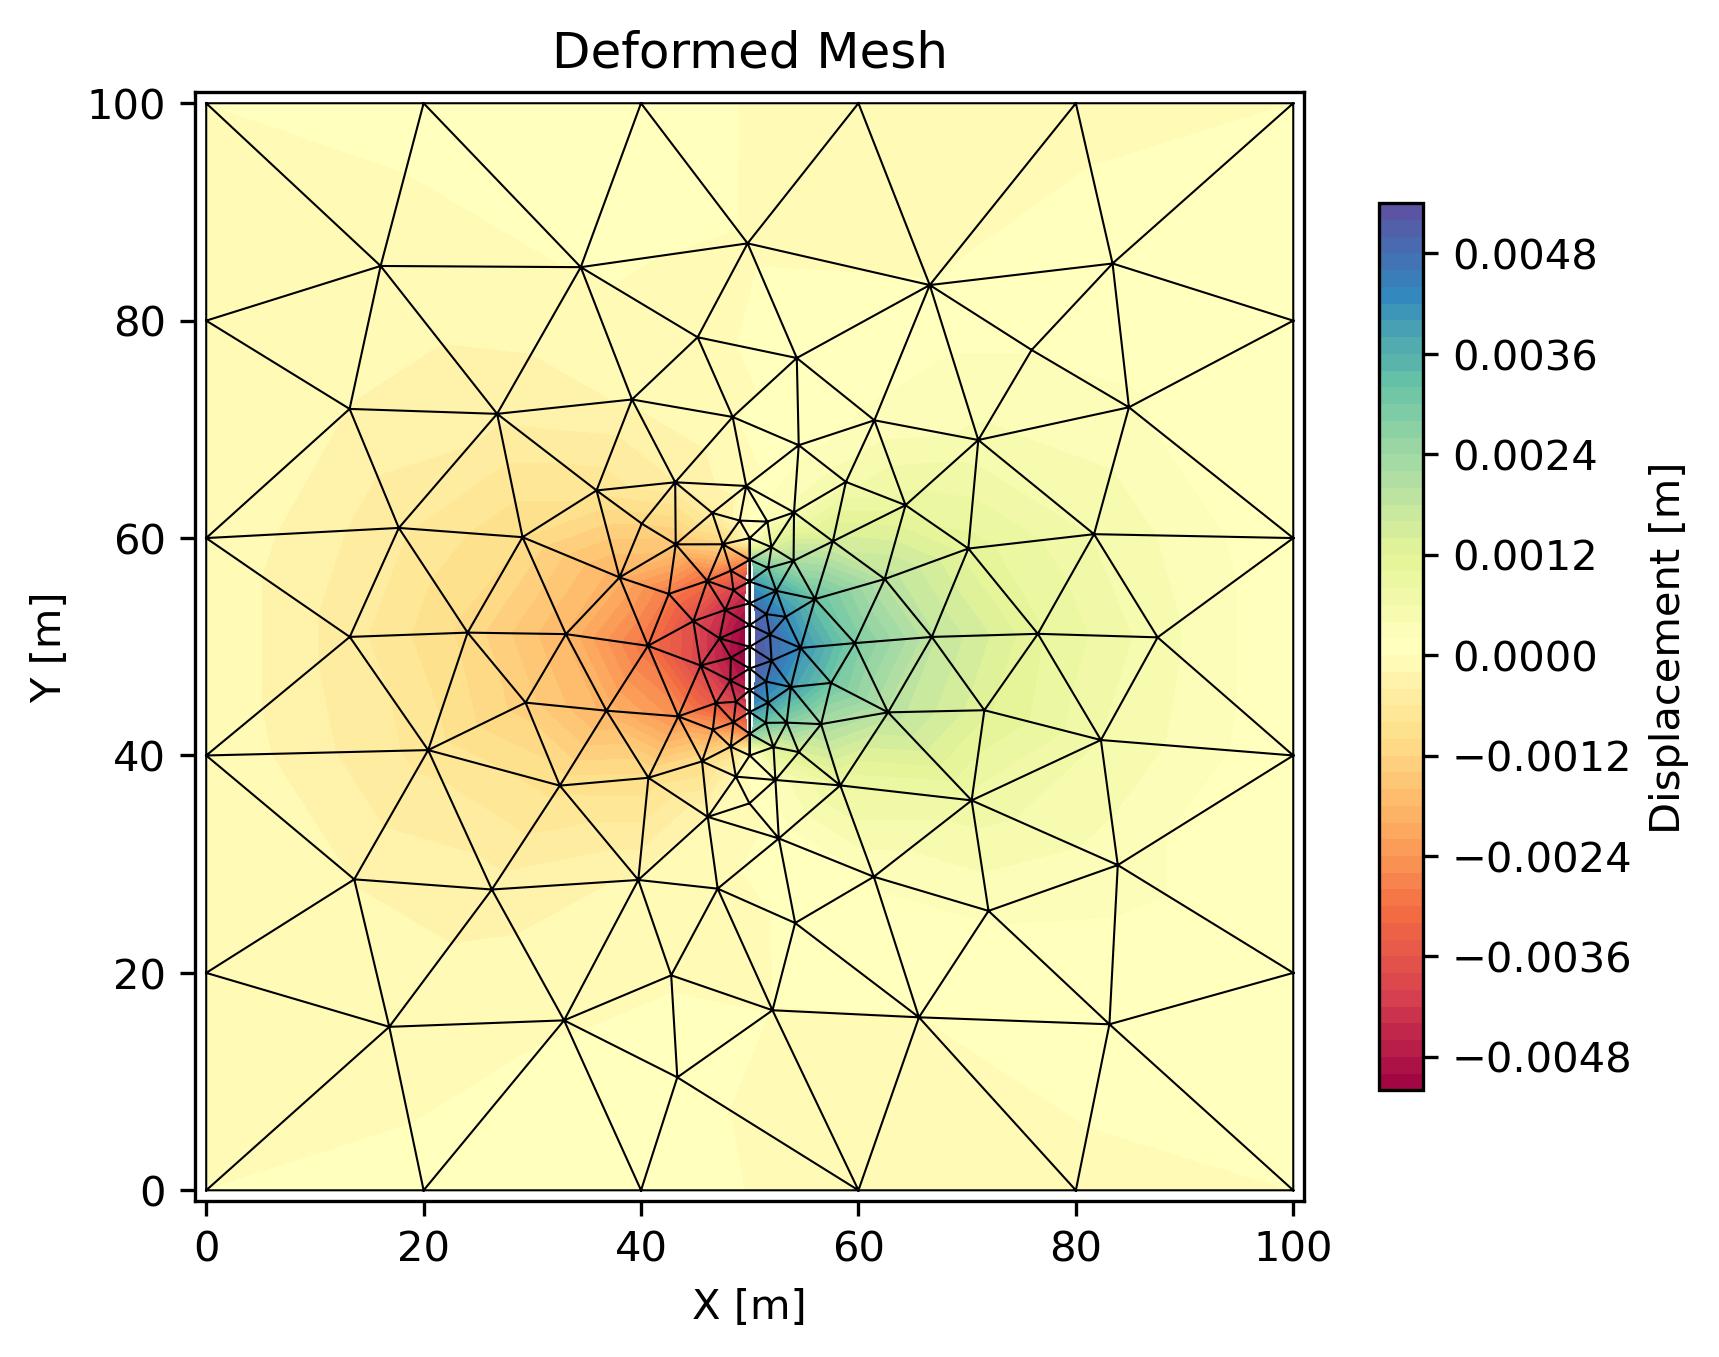

In [10]:
# Call Plotting function for deformed configuration
mesh_copy = (np.array(mesh[0]),np.array(mesh[1]))
move_mesh(mesh_copy, u,1e2) # 1e2 Exageration on fracture width for visualization
plot_deformed(mesh,mesh_copy, 'Deformed Mesh', ux)


## Compare Analytical and Numerical Solution

In [11]:
# Maximum Width of the Fracture - Eqn 7.5 - Section 7.3.2
E_prime = E/(1-nu**2) # Strain Modulus
Po = 10e6
c = 10

wo = (4 * Po * c) / E_prime

# Compare Analytical vs Numerical Solution
print('Max Fracture Aperture [m]')
print(f"Analytical Solution -->  {np.round(wo,6)}")
print(f"Numerical Solution -->  {np.max(aperture)}")

err = np.abs((wo - np.max(aperture))/wo)
print(f"Error --> {np.round(err,2)}")

Max Fracture Aperture [m]
Analytical Solution -->  0.0128
Numerical Solution -->  0.010427061468362808
Error --> 0.19


---  
### Strain & Stress

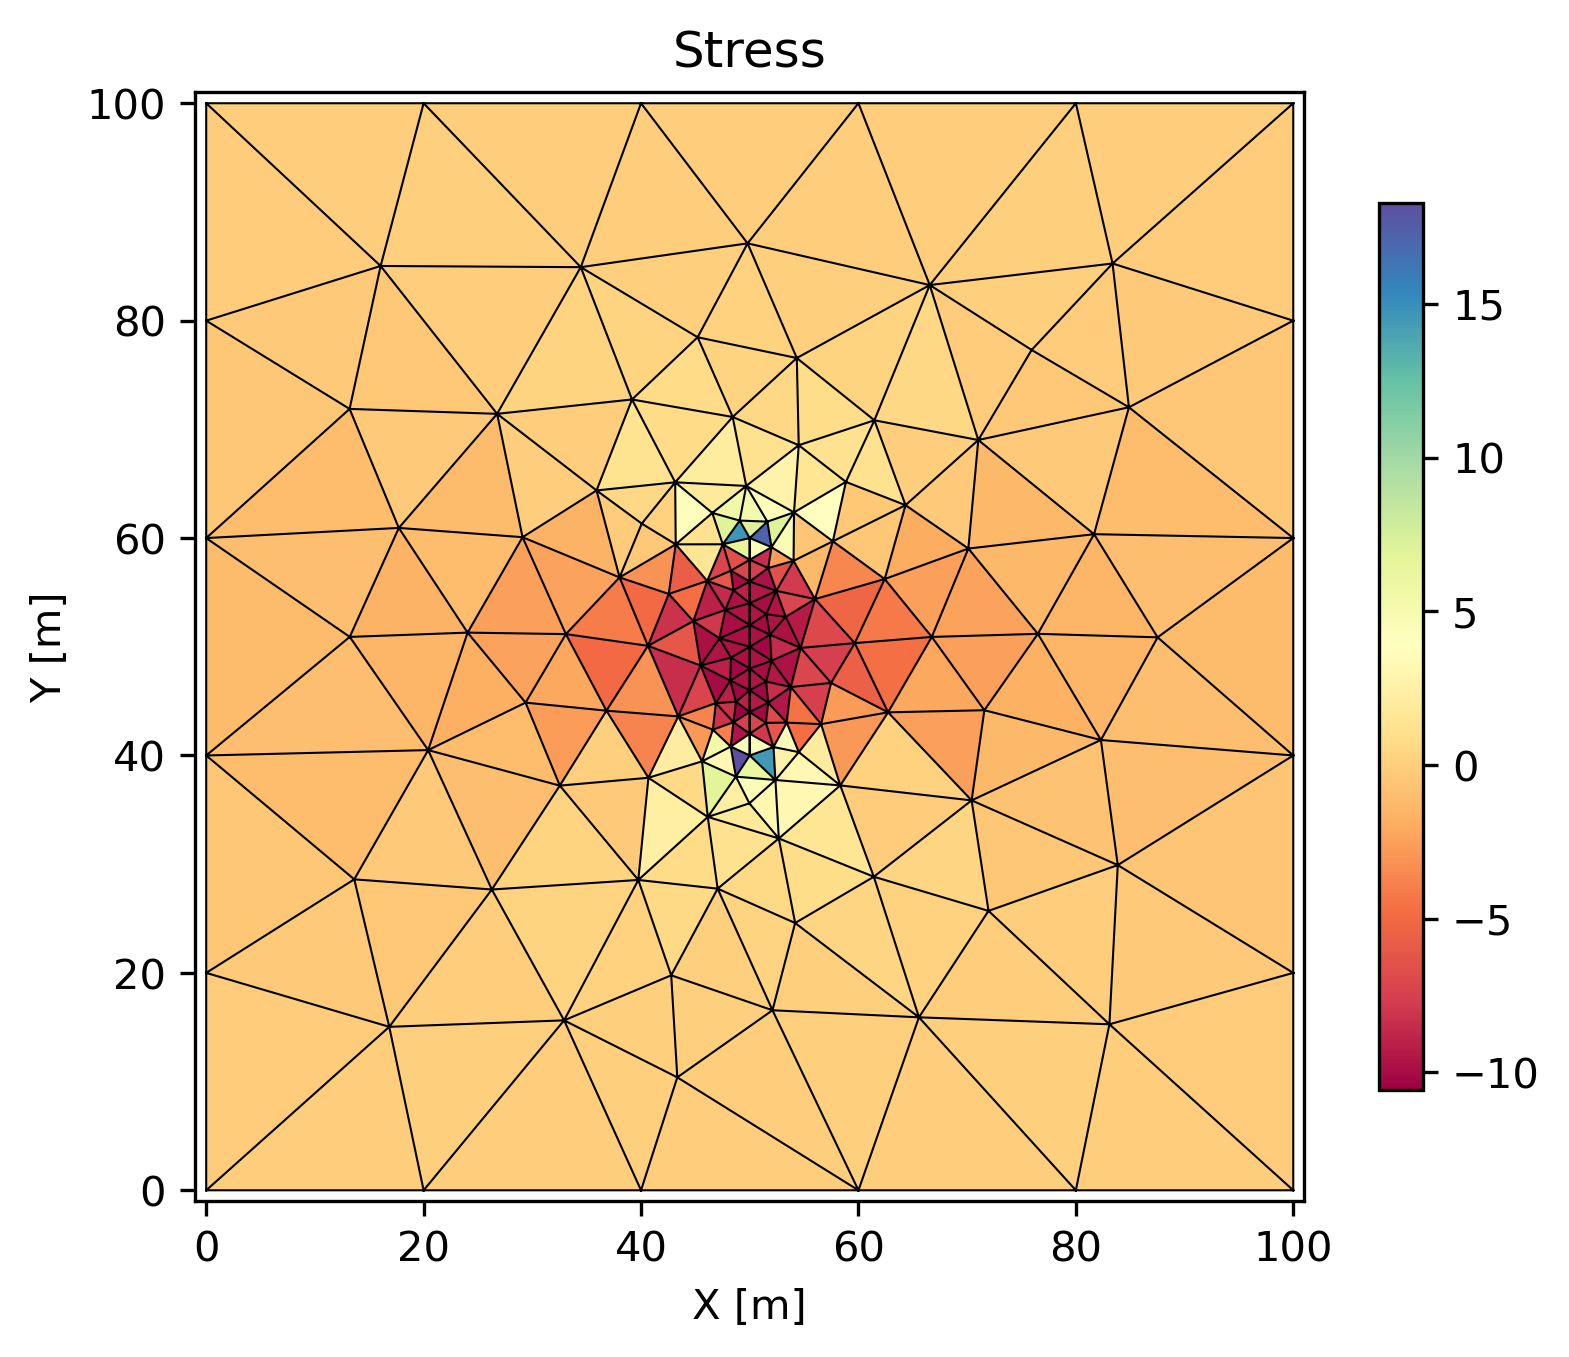

In [12]:
strain,stress = FEM.assemble_stress_strain(mesh,u,D)
FEM.plot(mesh, 'Stress',stress[:,0]/1e6)

## Strain

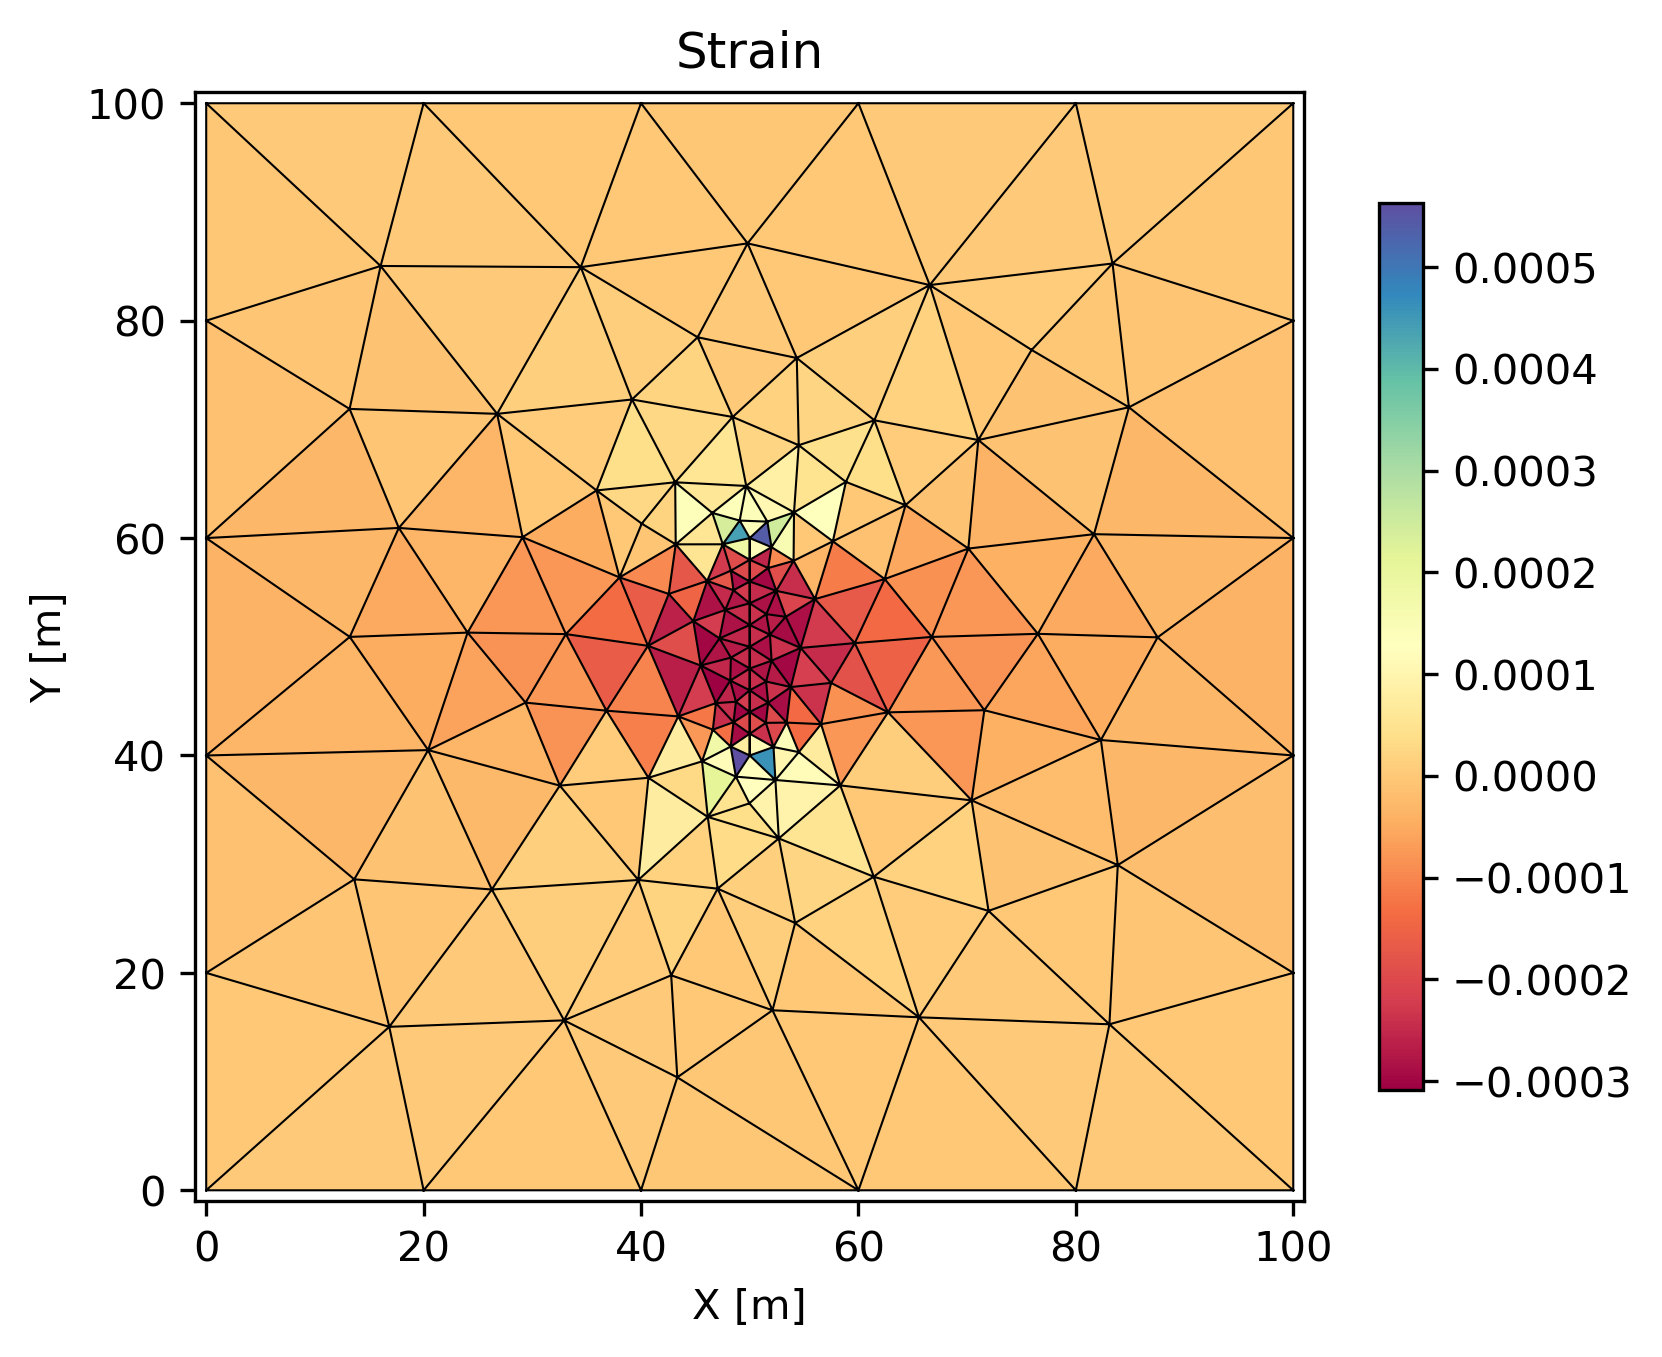

In [13]:
FEM.plot(mesh,'Strain', strain[:,0])